In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

In [3]:
df = pd.read_parquet('ST data.parquet')
data = df.copy()
# 拆分训练集与测试集
train, test = data[data.date <= '20231231'], data[data.date >= '20240101']
X_train, y_train = train.drop(['date', 'code', 'is_st'], axis=1), train['is_st']
X_test, y_test = test.drop(['date', 'code', 'is_st'], axis=1), test['is_st']
# 重采样
sampler = RandomOverSampler(random_state=1)
X_train_rsl, y_train_rsl = sampler.fit_resample(X_train, y_train)

model_xgb = XGBClassifier(n_estimators=90, max_depth=10, reg_alpha=8, reg_lambda=8, gamma=8, learning_rate=0.25, 
                          objective="binary:logistic", base_score=0.82, eval_metric="auc", seed=123)
model_xgb.fit(X_train_rsl, y_train_rsl)
y_pred_xgb = model_xgb.predict(X_test)
print("Test accuracy of XGBoost: {}".format(accuracy_score(y_test, y_pred_xgb)))
xgb_prob = model_xgb.predict_proba(X_test)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_prob[:, 1])
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("AUC Score: {}".format(auc_xgb))

Test accuracy of XGBoost: 0.9670483757887357
AUC Score: 0.9722709553789008


In [4]:
# 计算常用指标
def compute_indexes(tp, fp, tn, fn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    F1 = (2 * precision * recall) / (precision + recall)
    return accuracy, precision, recall, F1

mat = confusion_matrix(y_test, y_pred_xgb)
tn, fp, fn, tp = mat[0, 0], mat[0, 1], mat[1, 0], mat[1, 1]
compute_indexes(tp, fp, tn, fn)

(0.9670483757887357,
 0.46030330062444247,
 0.8376623376623377,
 0.5941278065630398)

In [17]:
res_pred = test.copy()
res_pred['pred'] = y_pred_xgb
res_pred = res_pred[res_pred['date'] >= '20240401']
symbols = res_pred[res_pred.code.isin(['000070.SZ', '300495.SZ', '000836.SZ', '002435.SZ'])].copy()
symbols

,date,code,net_profit,eps,gross_margin,net_margin,roe,roa,arturn,faturn,...,turnrate6m,cap,pb,pe,ps,ctdowndays,ctdownchg,shrcr,is_st,pred
129599,2024-04-30,000070.SZ,-3.907111e+07,0.0157,12.4331,1.8886,0.7410,0.2416,0.4804,0.8401,...,6.229638,758090.2879,3.9472,NaN,1.5057,3.0,0.145545,36.18,1,0
161374,2024-04-30,000836.SZ,-3.419424e+07,-0.0278,36.8425,-58.2295,-3.2843,-1.3320,0.1252,0.0828,...,3.079017,204228.9329,2.0299,NaN,7.1141,5.0,0.247476,11.92,1,1
325081,2024-04-30,002435.SZ,-2.436987e+07,-0.0081,26.3333,-2.4511,-0.2703,-0.1873,2.4537,0.7279,...,1.332883,351019.1777,0.9436,NaN,1.1605,3.0,0.161185,27.09,1,0
479260,2024-04-30,300495.SZ,-1.701636e+08,-0.2518,-56.1700,-21683.4120,-280.4251,-4.3309,0.0013,0.0108,...,3.227561,12137.0308,NaN,NaN,1.7099,8.0,0.704918,17.87,1,1


In [8]:
conn = pymysql.connect(
        host="192.168.7.93",
        user="quantchina",
        password="zMxq7VNYJljTFIQ8",
        database="wind",
        charset="gbk"
)
cursor = conn.cursor()

query = """
        select TRADE_DT, S_INFO_WINDCODE, S_VAL_MV
        from ASHAREEODDERIVATIVEINDICATOR
        where TRADE_DT between '20240401' and '20240531'
        order by TRADE_DT, S_INFO_WINDCODE
        """
cursor.execute(query)
data = cursor.fetchall()
cap = pd.DataFrame(data, columns=['date', 'code', 'mv'])
cap['mv'] = cap['mv'].astype(float)
cap['date'] = pd.to_datetime(cap['date'])

In [9]:
# 计算每月的平均市值作为当月结果
monthly_mv = cap.groupby([cap['date'].dt.strftime('%Y-%m'), 'code'])['mv'].mean()
monthly_mv

date     code     
2024-04  000001.SZ    2.035487e+07
         000002.SZ    8.787365e+06
         000004.SZ    1.565750e+05
         000005.SZ    8.785856e+04
         000006.SZ    4.999932e+05
                          ...     
2024-05  873706.BJ    9.812245e+04
         873726.BJ    1.509957e+05
         873806.BJ    2.465847e+05
         873833.BJ    7.317553e+04
         920002.BJ    2.029913e+05
Name: mv, Length: 10728, dtype: float64

In [10]:
cap04 = monthly_mv['2024-04']
cap05 = monthly_mv['2024-05']

In [18]:
st04 = res_pred[res_pred['is_st']==1]
cap04_st = pd.merge(cap04, st04[['code', 'is_st']], on='code')
cap04_st.head()

,code,mv,is_st
0,000007.SZ,1.431523e+05,1
1,000023.SZ,4.564155e+04,1
2,000070.SZ,7.085413e+05,1
3,000155.SZ,1.593966e+06,1
4,000156.SZ,1.370367e+06,1


In [ ]:
st_model = res_pred.loc[res_pred['pred']==1, 'code']
st_model = cap04[st_model]

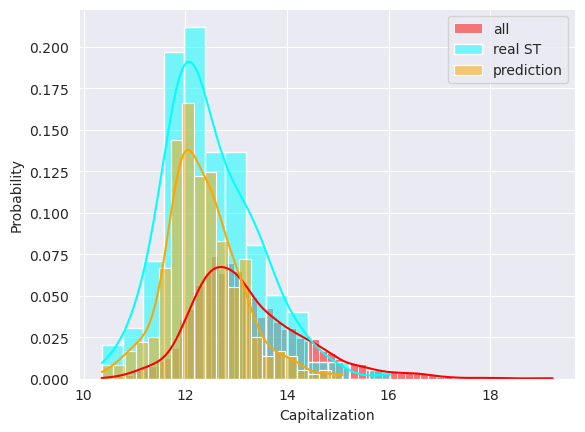

In [33]:
import seaborn as sns

sns.histplot(np.log(cap04), kde=True, stat='probability', alpha=0.5, color='red', label='all')
sns.histplot(np.log(cap04_st['mv']), kde=True, stat='probability', alpha=0.5, color='cyan', label='real ST')
sns.histplot(np.log(st_model), kde=True, stat='probability', alpha=0.5, color='orange', label='prediction')
plt.xlabel('Capitalization')
plt.legend()
plt.show()

In [34]:
from scipy.stats import skew, kurtosis
def eda(arr):
    arr = np.log(arr)
    l = [np.mean(arr), np.std(arr), skew(arr), kurtosis(arr)]
    return np.array(l).reshape([1,4])

tbl = pd.DataFrame(np.concatenate([eda(cap04), eda(cap04_st['mv']), eda(st_model)], axis=0), 
                   columns=['mean', 'std', 'skew', 'kurtosis'], 
                   index=['all', 'real_st', 'pred_st'])
print(tbl)

              mean       std      skew  kurtosis
all      13.229187  1.144062  1.036566  1.926998
real_st  12.477094  0.918327  0.651715  0.670944
pred_st  12.335971  0.734660  0.524844  1.030307


In [38]:
# 将最小和最大市值作为端点拆分10组
np.log(cap04.min()), np.log(cap04.max())

(10.353760697320826, 19.224153527933243)

In [72]:
bin_plot = pd.DataFrame(np.log(cap04).copy())
bins = np.linspace(np.log(cap04.min()), np.log(cap04.max()), 11)
bin_plot['group'] = pd.cut(bin_plot['mv'], bins=bins, labels=range(1, 11))
bin_plot.head()

,mv,group
code,,
000001.SZ,16.828831,8
000002.SZ,15.988825,7
000004.SZ,11.961290,2
000005.SZ,11.383484,2
000006.SZ,13.122350,4


In [89]:
# 统计市值落在每个区间内的股票数量
count_df = pd.DataFrame(bin_plot['group'].value_counts().to_frame('all').sort_index())
group_st = bin_plot[bin_plot.index.isin(cap04_st.code)].copy()
group_model = bin_plot[bin_plot.index.isin(st_model.index)].copy()

In [102]:
count_df['ST'] = group_st['group'].value_counts().sort_index()
count_df['model'] = group_model['group'].value_counts().sort_index()

In [103]:
freq_df = count_df / count_df.sum(axis=0)
freq_df

,all,ST,model
1,0.015663,0.060606,0.055402
2,0.110013,0.338384,0.371191
3,0.372739,0.333333,0.407202
4,0.264964,0.191919,0.130194
5,0.143949,0.060606,0.030471
6,0.055752,0.010101,0.005540
7,0.023494,0.005051,0.000000
8,0.009137,0.000000,0.000000
9,0.002797,0.000000,0.000000
10,0.001492,0.000000,0.000000


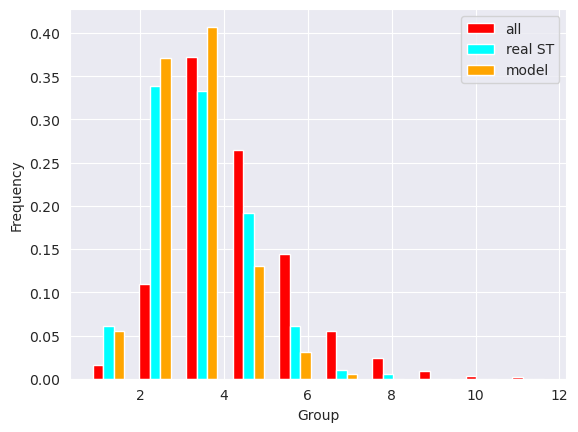

In [105]:
seq = np.linspace(1, 11, 10) 
plt.bar(x=seq, height=freq_df[count_df.columns[0]], color='red', width=0.25, label='all')
plt.bar(x=seq+0.25, height=freq_df[count_df.columns[1]], color='cyan', width=0.25, label='real ST')
plt.bar(x=seq+0.5, height=freq_df[count_df.columns[2]], color='orange', width=0.25, label='model')
plt.xlabel('Group')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
bins